## Identifiability under Fixed Causal Dynamics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import leap
import numpy as np
import scipy
from LiLY.datasets.sim_dataset import StationaryDataset
from LiLY.modules.stationary import StationaryProcess
from LiLY.modules.metrics.correlation import correlation
import random
import seaborn as sns
from torchvision import transforms
from torchvision.utils import save_image, make_grid
from leap.tools.utils import load_yaml
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = StationaryDataset(directory = '/srv/data/lily/data', 
                         transition='noisecoupled_gaussian_ts_2lag')
num_validation_samples = 2500
train_data, val_data = random_split(data, [len(data)-num_validation_samples, num_validation_samples])
train_loader = DataLoader(train_data, batch_size=2560, shuffle=True, pin_memory=True)
val_loader   = DataLoader(val_data, batch_size=16, shuffle=False, pin_memory=True)

In [4]:
cfg = load_yaml('../LiLY/configs/stationary_2lag.yaml')

In [ ]:
StationaryProcess(input_dim=cfg['VAE']['INPUT_DIM'],
)

In [13]:
model = StationaryProcess.load_from_checkpoint(checkpoint_path='/srv/data/lily/log/weiran/stationary_2lag/lightning_logs/version_46/checkpoints/epoch=49-step=77342.ckpt',
                              input_dim=cfg['VAE']['INPUT_DIM'],
                              length=cfg['VAE']['LENGTH'],
                              z_dim=cfg['VAE']['LATENT_DIM'], 
                              lag=cfg['VAE']['LAG'],
                              hidden_dim=cfg['VAE']['ENC']['HIDDEN_DIM'],
                              trans_prior=cfg['VAE']['TRANS_PRIOR'],
                              lr=cfg['VAE']['LR'],
                              beta=cfg['VAE']['BETA'],
                              gamma=cfg['VAE']['GAMMA'],
                              decoder_dist=cfg['VAE']['DEC']['DIST'],
                              correlation=cfg['MCC']['CORR'])

/home/weiran/project/LiLY/LiLY/modules/components/beta.py:299: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


In [14]:
batch = next(iter(train_loader))
batch_size = batch['xt'].shape[0]

In [15]:
latent_size = 8

In [16]:
z, mu, logvar = model.forward(batch)
mu = mu.view(batch_size, -1, latent_size)
A = mu[:,2,:].detach().cpu().numpy()
B = batch['yt'][:,2,:].detach().cpu().numpy()
C = np.zeros((latent_size,latent_size))
for i in range(latent_size):
    C[i] = -np.abs(np.corrcoef(B, A, rowvar=False)[i,latent_size:])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(C)
A = A[:, col_ind]
mask = np.ones(latent_size)
for i in range(latent_size):
    if np.corrcoef(B, A, rowvar=False)[i,latent_size:][i] > 0:
        mask[i] = -1
print("Permutation:",col_ind)
print("Sign Flip:", mask)

Permutation: [7 4 1 0 6 2 5 3]
Sign Flip: [ 1.  1.  1. -1.  1.  1.  1.  1.]


In [24]:
figure_path = '/home/weiran/figs/'

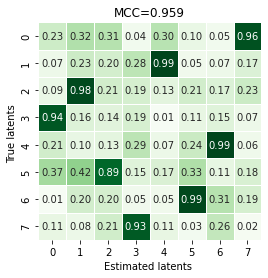

In [30]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages(figure_path + '/mcc_fixed.pdf') as pdf:
    fig = plt.figure(figsize=(4,4))
    sns.heatmap(-C, vmin=0, vmax=1, annot=True, fmt=".2f", linewidths=.5, cbar=False, cmap='Greens')
    plt.xlabel("Estimated latents ") 
    plt.ylabel("True latents ") 
    plt.title("MCC=%.3f"%np.abs(C[row_ind, col_ind]).mean());
    pdf.savefig(fig, bbox_inches="tight")

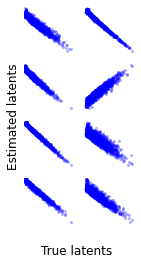

In [32]:
fig, axs = plt.subplots(4,2, figsize=(2,4))
with PdfPages(figure_path + '/scatter_fixed.pdf') as pdf:
    for i in range(8):
        row = i // 2
        col = i % 2
        ax = axs[row,col]
        ax.scatter(B[:,i], A[:,i], s=4, color='b', alpha=0.25)
        ax.axis('off')
    #     ax.set_xlabel('Ground truth latent')
    #     ax.set_ylabel('Estimated latent')
    #     ax.grid('..')
    # fig.tight_layout()
    fig.supxlabel('True latents')
    fig.supylabel('Estimated latents')
    pdf.savefig(fig, bbox_inches="tight")

Text(0.02, 0.5, 'Estimated latents')

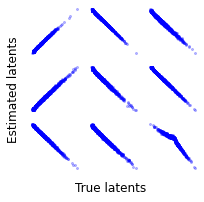

In [354]:
fig, axs = plt.subplots(3,3, figsize=(3,3))
for i in range(9):
    row = i // 3
    col = i % 3
    ax = axs[row,col]
    ax.scatter(B[:,i], A[:,i], s=4, color='b', alpha=0.25)
    ax.axis('off')
#     ax.set_xlabel('Ground truth latent')
#     ax.set_ylabel('Estimated latent')
#     ax.grid('..')
# fig.tight_layout()
fig.supxlabel('True latents')
fig.supylabel('Estimated latents')

In [ ]:
NL + Generalized Gaussian Noise

In [188]:
theta_dyn = np.zeros((5,2))
for d_idx in range(5):
    W2 = np.load('/srv/data/lily/data/pnl_modular_5/source/W2_%d.npy'%d_idx)
    theta_dyn[d_idx, 0] = W2[1,2]
    theta_dyn[d_idx, 1] = W2[3,4]

In [189]:
theta_hat = model.dyn_embed_func(torch.LongTensor([0,1,2,3,4])).detach().numpy()

In [190]:
from matplotlib.patches import FancyArrowPatch 

In [191]:
from matplotlib.patches import FancyArrowPatch 

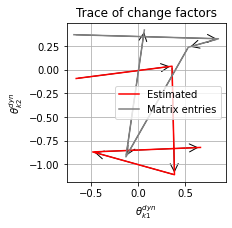

In [345]:
theta_hat = theta_hat.detach().numpy()
theta_dyn = theta_dyn.detach().numpy()

fig, ax = plt.subplots(figsize=(3,3))
ax.set_aspect("equal")
ax.plot(theta_hat[:,0], theta_hat[:,1], color='red', label='Estimated')
ax.plot(theta_dyn[:,0], theta_dyn[:,1], color='gray', label='Matrix entries')
arrow(theta_hat[:,0], theta_hat[:,1], ax, 3)
arrow(theta_dyn[:,0], theta_dyn[:,1], ax, 3)
plt.tight_layout()
plt.legend()
plt.grid()
plt.xlabel(r'$\theta_{k1}^{dyn}$')
plt.ylabel(r'$\theta_{k2}^{dyn}$')
plt.title('Trace of change factors')
def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)

In [359]:
np.linalg.inv(theta_hat.T @ theta_hat) @ (theta_hat.T @ theta_dyn)

array([[ 0.7634366 ,  0.5584793 ],
       [-0.02744316,  0.16442966]], dtype=float32)

In [355]:
R = np.random.rand(2,2)

In [357]:
(theta_hat - theta_dyn @ R)

array([[-0.69237621, -0.19672908],
       [-0.36935343, -0.41940991],
       [-0.10224308, -1.41819704],
       [ 0.48799991, -0.15370551],
       [ 0.2149604 , -1.14880499]])

In [ ]:
5,2 

In [358]:
theta_dyn.shape

(5, 2)

In [290]:
rotation

Parameter containing:
tensor([-0.2278], requires_grad=True)

In [270]:
rotation.grad

tensor([0.])

In [255]:
rotation.data.add_(-1, rotation.grad)

/tmp/ipykernel_2979/960937127.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.data.add_(-1, rotation.grad)


TypeError: add_() takes 1 positional argument but 2 were given

/tmp/ipykernel_2979/587205299.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.grad[0]


TypeError: 'NoneType' object is not subscriptable

In [244]:
rotation.grad

/tmp/ipykernel_2979/1116664041.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  rotation.grad


In [240]:
rotation.grad[0]

tensor(2.5513)

In [225]:
rotation.grad

tensor([0.2551])

In [217]:
loss

tensor(0.4698, grad_fn=<MseLossBackward>)

In [207]:
rotation_matrix

tensor([[1., 0.],
        [-0., 1.]], grad_fn=<CopySlices>)

In [202]:
rotation

Parameter containing:
tensor([0.], requires_grad=True)

In [194]:
theta_hat.shape

(5, 2)

In [167]:
MeanMat = np.load('/srv/data/lily/data/pnl_modular_5/source/meanMat.npy')
VarMat = np.load('/srv/data/lily/data/pnl_modular_5/source/varMat.npy')

In [181]:
theta_obs = np.concatenate((MeanMat,VarMat), axis=-1)

In [182]:
theta_hat = model.obs_embed_func(torch.LongTensor([0,1,2,3,4])).detach().numpy()

Text(0, 0.5, '$\\theta_{1k}^{obs}$')

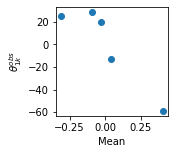

In [185]:
plt.figure(figsize=(2,2))
plt.scatter(theta_obs[:,0], theta_hat[:,0])
plt.xlabel('Mean')
plt.ylabel(r'$\theta_{1k}^{obs}$')

Text(0, 0.5, '$\\theta_{2k}^{obs}$')

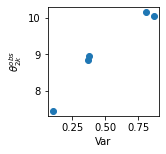

In [187]:
plt.figure(figsize=(2,2))
plt.scatter(theta_obs[:,1], theta_hat[:,1])
plt.xlabel('Var')
plt.ylabel(r'$\theta_{2k}^{obs}$')

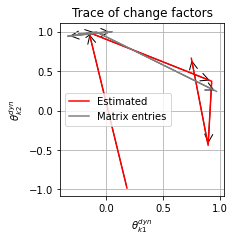

In [165]:
fig, ax = plt.subplots(figsize=(3,3))
# ax.set_aspect("equal")
plt.tight_layout()
ax.plot(theta_hat[:,0], theta_hat[:,1], color='red', label='Estimated')
ax.plot(theta_obs[:,0], theta_obs[:,1], color='gray', label='Matrix entries')
arrow(theta_hat[:,0], theta_hat[:,1], ax, 3)
arrow(theta_obs[:,0], theta_obs[:,1], ax, 3)
plt.legend()
plt.grid()
plt.xlabel(r'$\theta_{k1}^{dyn}$')
plt.ylabel(r'$\theta_{k2}^{dyn}$')
plt.title('Trace of change factors')
def arrow(x,y,ax,n):
    d = len(x)//(n+1)    
    ind = np.arange(d,len(x),d)
    for i in ind:
        ar = FancyArrowPatch ((x[i-1],y[i-1]),(x[i],y[i]), 
                              arrowstyle='->', mutation_scale=20)
        ax.add_patch(ar)